In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

In [2]:
# Load data
df = pd.read_csv('D:\Python\demand-prediction\Dataset\SKU4.csv')
df['date'] = pd.to_datetime(df['date'], format='%m/%d/%Y')
df.set_index('date', inplace=True)
df.sort_index(inplace=True)

# Split data into training, validation, and test sets immediately after import
train_size = int(len(df) * 0.70)
val_size = int(len(df) * 0.15)

train = df.iloc[:train_size].copy()
val = df.iloc[train_size:train_size + val_size].copy()
test = df.iloc[train_size + val_size:].copy()

# Define holidays and promotions
holidays = [
    'New Year', 'Victory over Genocide Day', 'International Women Day',
    'Khmer New Year Day 1', 'Khmer New Year Day 2', 'Khmer New Year Day 3',
    'Labour Day', 'Visak Bochea Day', 'Royal Plowing Ceremony', "King's Birthday",
    "King's Mother's Birthday", 'Constitutional Day', 'Pchum Ben Day 1',
    'Pchum Ben Day 2', "Commemoration Day of King's Father",
    "King's Coronation Day", 'Independence Day', 'Water Festival Day 1',
    'Water Festival Day 2', 'Water Festival Day 3', 'Chrismas'
]

promotions = [
    'Discount Promotion', 'Loyalty Program Promotion',
    'Bundle Promotion', 'Flash Sale Promotion'
]

# Function to apply feature engineering to each subset
def apply_features(df):
    df['month'] = df.index.month
    df['day_of_week'] = df.index.dayofweek
    df['is_holiday'] = df[holidays].any(axis=1).astype(int)
    df['is_promotion'] = df[promotions].any(axis=1).astype(int)
    df['holiday_or_promotion'] = (df['is_holiday'] | df['is_promotion']).astype(int)
    df['holiday_and_promotion'] = (df['is_holiday'] & df['is_promotion']).astype(int)
    df['prev_day_holiday'] = df['is_holiday'].shift(1).fillna(0).astype(int)
    df['next_day_promotion'] = df['is_promotion'].shift(-1).fillna(0).astype(int)
    return df



In [3]:
# Apply feature engineering to each dataset
train = apply_features(train)
val = apply_features(val)
test = apply_features(test)

# Scale 'sales' separately
sales_scaler = MinMaxScaler()
train['sales_scaled'] = sales_scaler.fit_transform(train[['sales']])
val['sales_scaled'] = sales_scaler.transform(val[['sales']])
test['sales_scaled'] = sales_scaler.transform(test[['sales']])

# Scale other numerical features
numerical_features = ['month', 'day_of_week', 'is_holiday', 'is_promotion',
                      'holiday_or_promotion', 'holiday_and_promotion', 'prev_day_holiday', 'next_day_promotion']
feature_scaler = MinMaxScaler()
train[numerical_features] = feature_scaler.fit_transform(train[numerical_features])
val[numerical_features] = feature_scaler.transform(val[numerical_features])
test[numerical_features] = feature_scaler.transform(test[numerical_features])

# Define features for the model
features = numerical_features + ['sales_scaled']

In [4]:
# Define sequence length and target
sequence_length = 30
target = 'sales_scaled'

# Function to create sequences
def create_sequences(data, features, target, sequence_length):
    X, y = [], []
    data_values = data[features].values
    target_values = data[target].values
    for i in range(sequence_length, len(data)):
        X.append(data_values[i - sequence_length:i])
        y.append(target_values[i])
    return np.array(X), np.array(y)

# Create sequences for training and validation
X_train, y_train = create_sequences(train, features, target, sequence_length)
X_val, y_val = create_sequences(val, features, target, sequence_length)


In [5]:
# Build the LSTM model
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(sequence_length, len(features))),
    Dropout(0.2),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.1),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

Epoch 1/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 18s 67ms/step - loss: 0.0309 - val_loss: 0.0119
Epoch 2/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0132 - val_loss: 0.0225
Epoch 3/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0138 - val_loss: 0.0116
Epoch 4/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0146 - val_loss: 0.0073
Epoch 5/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0099 - val_loss: 0.0077
Epoch 6/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0122 - val_loss: 0.0071
Epoch 7/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0105 - val_loss: 0.0065
Epoch 8/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0105 - val_loss: 0.0081
Epoch 9/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0088 - val_loss: 0.0091
Epoch 10/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0094 - val_loss: 0.0057
Epoch 11/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0074 - val_loss: 0.0055
Epoch 12/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/ste

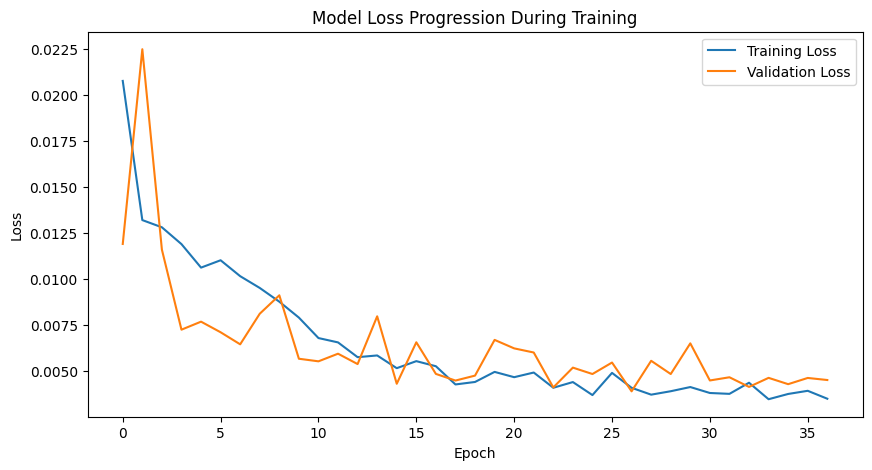

In [6]:
# Define early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

# Visualize training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Progression During Training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [7]:
# Rolling window predictions on the test set
last_train_sequence = train[features].values[-sequence_length:]
current_sequence = last_train_sequence.copy()

predictions = []
prediction_intervals = []
dates = test.index

for i in range(len(test)):
    # Reshape the current sequence
    input_sequence = np.array([current_sequence])
    
    # Make prediction
    pred = model.predict(input_sequence)
    
    # Store the prediction
    predictions.append(pred[0][0])
    
    # Calculate prediction interval (95% confidence interval assuming normal distribution)
    residuals = y_train - model.predict(X_train).flatten()
    std_residuals = np.std(residuals)
    lower_bound = pred[0][0] - 1.96 * std_residuals
    upper_bound = pred[0][0] + 1.96 * std_residuals
    prediction_intervals.append((lower_bound, upper_bound))
    
    # Update the current sequence
    new_entry = test[features].iloc[i].values
    new_entry[0] = pred  # Replace the 'sales_scaled' feature with the predicted value
    
    current_sequence = np.vstack((current_sequence[1:], new_entry))



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
39/39 ━━━━━━━━━━━━━━━━━━━

In [8]:
# Inverse transform predictions and actual values
predictions_inv = sales_scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
actual_inv = sales_scaler.inverse_transform(test[target].values.reshape(-1, 1))

# Inverse transform prediction intervals
prediction_intervals_inv = [(sales_scaler.inverse_transform([[low]])[0][0],
                             sales_scaler.inverse_transform([[high]])[0][0])
                            for low, high in prediction_intervals]

# Create a DataFrame for analysis
test_results = pd.DataFrame({
    'date': dates,
    'actual_sales': actual_inv.flatten(),
    'predicted_sales': predictions_inv.flatten(),
    'lower_ci': [interval[0] for interval in prediction_intervals_inv],
    'upper_ci': [interval[1] for interval in prediction_intervals_inv],
    'is_holiday': test['is_holiday'].values,
    'is_promotion': test['is_promotion'].values,
    'holiday_or_promotion': test['holiday_or_promotion'].values,
    'holiday_and_promotion': test['holiday_and_promotion'].values
})


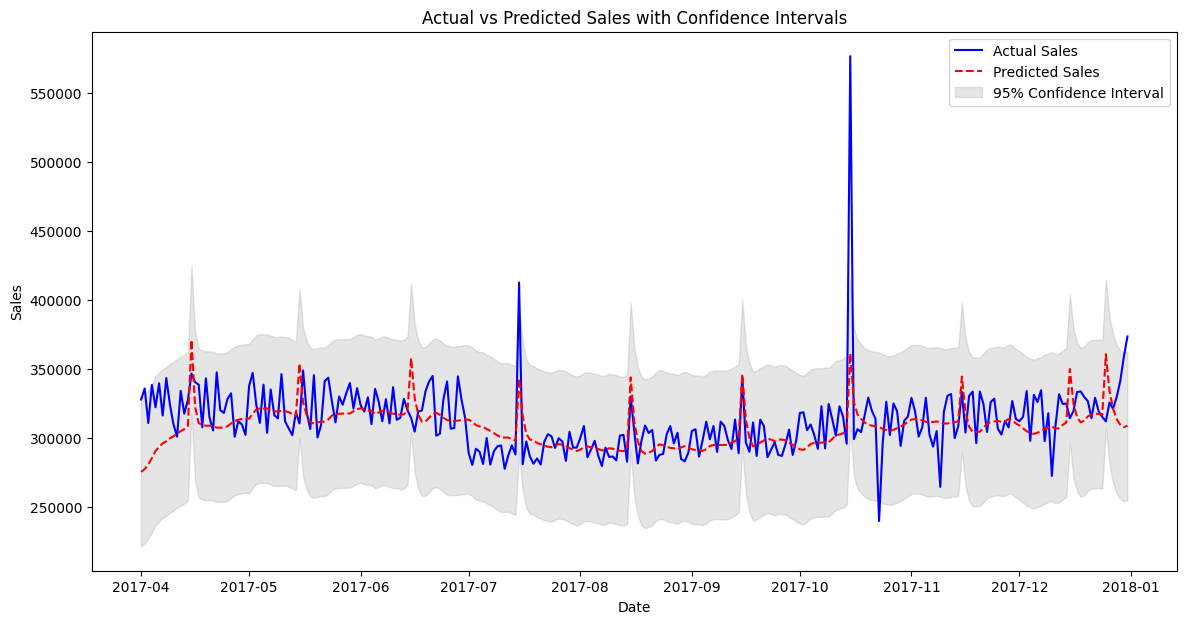

In [9]:
# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(test_results['date'], test_results['actual_sales'], label='Actual Sales', color='blue')
plt.plot(test_results['date'], test_results['predicted_sales'], label='Predicted Sales', color='red', linestyle='--')
plt.fill_between(test_results['date'], test_results['lower_ci'], test_results['upper_ci'], color='gray', alpha=0.2, label='95% Confidence Interval')
plt.title('Actual vs Predicted Sales with Confidence Intervals')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()


In [10]:

# Calculate MAE, MAPE, MSE, and R2
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
mae = mean_absolute_error(test_results['actual_sales'], test_results['predicted_sales'])
mse = mean_squared_error(test_results['actual_sales'], test_results['predicted_sales'])
mape = mean_absolute_percentage_error(test_results['actual_sales'], test_results['predicted_sales'])
r2 = r2_score(test_results['actual_sales'], test_results['predicted_sales'])

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"MAPE: {mape:.4f}")
print(f"R2: {r2:.4f}")

MAE: 15387.2528
MSE: 533028650.6348
MAPE: 0.0475
R2: 0.1705


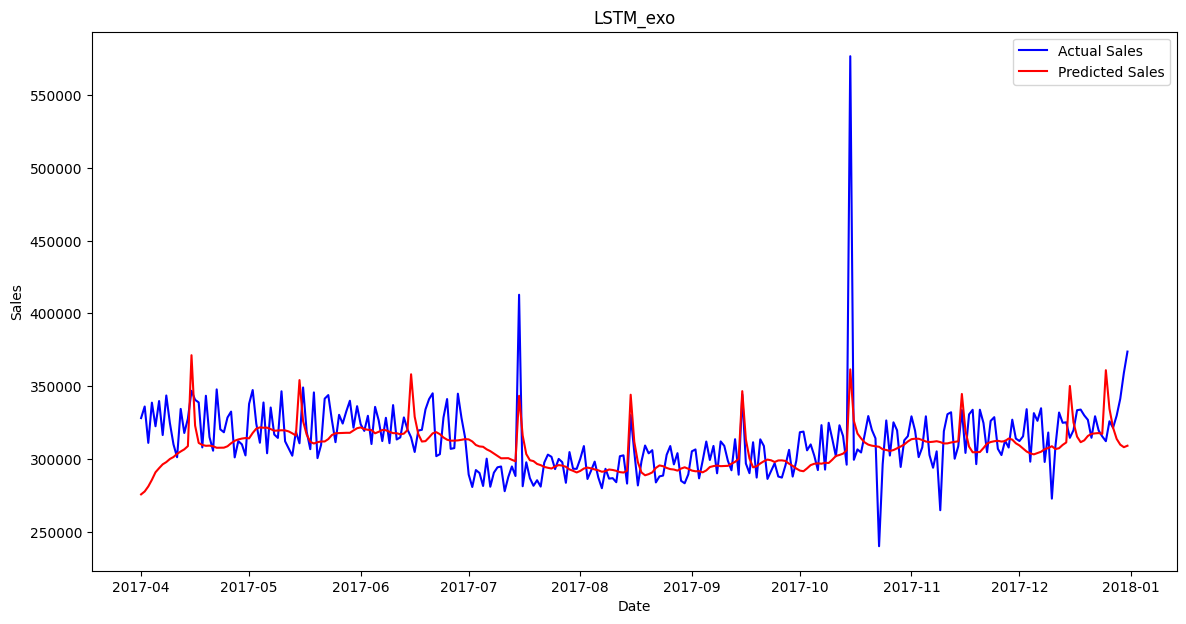

In [11]:
# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(test_results['date'], test_results['actual_sales'], label='Actual Sales', color='blue')
plt.plot(test_results['date'], test_results['predicted_sales'], label='Predicted Sales', color='red')
# plt.fill_between(test_results['date'], test_results['lower_ci'], test_results['upper_ci'], color='gray', alpha=0.2, label='95% Confidence Interval')
plt.title('LSTM_exo')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()


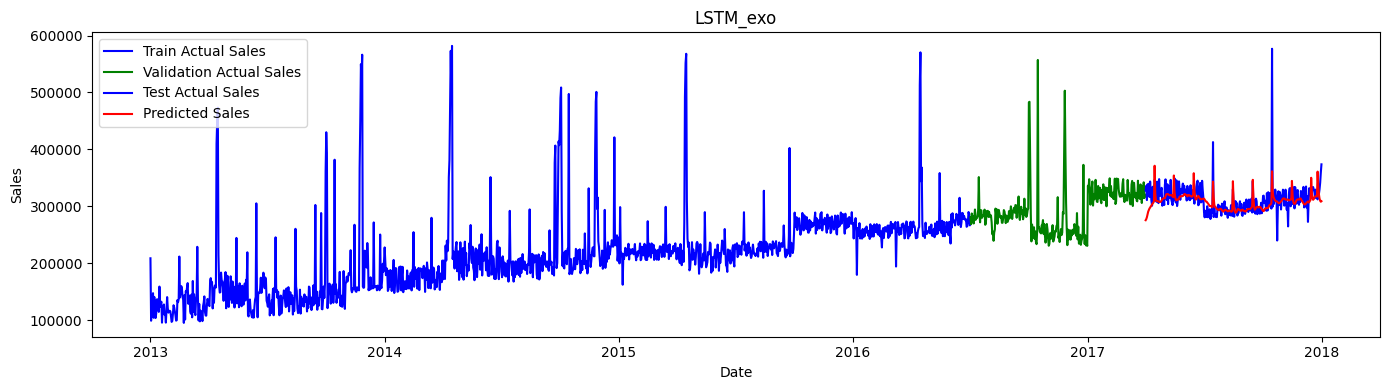

In [15]:
# Plot the entire graph for train, validation, test, and prediction

# Prepare inverse-transformed data for train and validation sets as well
train_sales_inv = sales_scaler.inverse_transform(train['sales_scaled'].values.reshape(-1, 1))
val_sales_inv = sales_scaler.inverse_transform(val['sales_scaled'].values.reshape(-1, 1))

# Define indices for easier plotting
train_idx = train.index
val_idx = val.index
test_idx = test_results['date']

# Plot the actual sales and predictions across the train, validation, and test sets
plt.figure(figsize=(14, 4))
plt.plot(train_idx, train_sales_inv, label='Train Actual Sales', color='blue')
plt.plot(val_idx, val_sales_inv, label='Validation Actual Sales', color='green')
plt.plot(test_idx, test_results['actual_sales'], label='Test Actual Sales', color='blue')
plt.plot(test_idx, test_results['predicted_sales'], label='Predicted Sales', color='red')

# Add title and labels for clarity
plt.title('LSTM_exo')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()
